In [24]:
!pip install -q transformers

In [25]:
!pip install -q datasets jiwer

In [26]:
import pandas as pd
import os

# Path to the folders
images_folder = '/kaggle/input/arabic-words/ALL_IMAGES/ALL_IMAGES'
labels_folder = '/kaggle/input/arabic-words/ALL_TEXTS/ALL_TEXTS'

# List to store image paths and labels
data = []

# Iterate over files in images folder
for image_file in os.listdir(images_folder):
    if image_file.endswith(('.png', '.jpg', '.jpeg')):
        # Get image path
        image_path = os.path.join(images_folder, image_file)
        
        # Get corresponding label
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(labels_folder, label_file)
        if os.path.exists(label_path):
           with open(label_path, 'r', encoding='utf-8') as f:  # Use UTF-8 encoding
                    label = f.read().strip()
        else:
            label = None
        
        # Add image path and label to data list
        data.append({'image_path': image_path, 'label': label})

# Create DataFrame from the data list
df = pd.DataFrame(data)
df.head()

,image_path,label
0,/kaggle/input/arabic-words/ALL_IMAGES/ALL_IMAG...,عبدالنبي
1,/kaggle/input/arabic-words/ALL_IMAGES/ALL_IMAG...,مصطفى
2,/kaggle/input/arabic-words/ALL_IMAGES/ALL_IMAG...,مرجان
3,/kaggle/input/arabic-words/ALL_IMAGES/ALL_IMAG...,محمد
4,/kaggle/input/arabic-words/ALL_IMAGES/ALL_IMAG...,حسن


In [27]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [28]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class Dataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=47):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['image_path'][idx]
        text = self.df['label'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [29]:
from transformers import TrOCRProcessor
from transformers import AutoTokenizer
from transformers import VisionEncoderDecoderModel

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

tokenizer2 = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")
processor.tokenizer = tokenizer2

#model defining
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-stage1")
train_dataset = Dataset(root_dir='',
                           df=train_df,
                           processor=processor)
eval_dataset = Dataset(root_dir='',
                           df=test_df,
                           processor=processor)

Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.47.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 384,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 1024,
  "decode

In [30]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 4859
Number of validation examples: 540


In [31]:
# max_label_size = 0
# # Iterate over all indices in eval_dataset
# for idx in range(len(train_dataset)):
#     encoding = train_dataset[idx]
#     for k, v in encoding.items():
#         if k == 'labels' and v.shape[0] > max_label_size:
#             max_label_size = v.shape[0]
#             max_label_idx = idx

# for idx in range(len(eval_dataset)):
#     encoding = eval_dataset[idx]
#     for k, v in encoding.items():
#         if k == 'labels' and v.shape[0] > max_label_size:
#             max_label_size = v.shape[0]
#             max_label_idx = idx

# if max_label_idx is not None:
#     print(f"Maximum label size found at index {max_label_idx}, with size {max_label_size}.")
# else:
#     print("No 'labels' key found in eval_dataset.")


In [32]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([47])


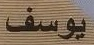

In [33]:
image = Image.open(train_dataset.root_dir + train_df['image_path'][0]).convert("RGB")
image

In [34]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.tokenizer.decode(labels, skip_special_tokens=True)
print(label_str)
print(labels)

يوسف
tensor([  33, 1982,   34,   31,   31,   31,   31,   31,   31,   31,   31,   31,
          31,   31,   31,   31,   31,   31,   31,   31,   31,   31,   31,   31,
          31,   31,   31,   31,   31,   31,   31,   31,   31,   31,   31,   31,
          31,   31,   31,   31,   31,   31,   31,   31,   31,   31,   31])


In [35]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=16)

In [36]:
# from transformers import VisionEncoderDecoderModel
# import torch

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
# model.to(device)
# model.summary

In [37]:
import torch.nn as nn
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

#model.config.vocab_size = model.config.decoder.vocab_size

model.decoder.config.vocab_size = processor.tokenizer.vocab_size
model.config.vocab_size = model.config.decoder.vocab_size
model.decoder.output_projection = nn.Linear(256, processor.tokenizer.vocab_size)
model.decoder.model.decoder.embed_tokens = nn.Embedding(processor.tokenizer.vocab_size, 256, padding_idx=1)


# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 47
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 8

In [38]:
!pip install evaluate

In [39]:


import evaluate

cer_metric = evaluate.load("cer")
wer_metric = evaluate.load("wer")


In [40]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

def compute_wer(pred_ids, label_ids):
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return wer

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTSdpaAttention(
            (attention): DeiTSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense):

In [45]:
import torch
from torch.utils.data import DataLoader
from transformers import AdamW, get_scheduler
from tqdm.notebook import tqdm
from torch.cuda.amp import GradScaler, autocast

# Ensure your train_dataset and eval_dataset are defined and set an appropriate batch size.
batch_size = 8  # adjust as needed
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,    # adjust based on your system
    pin_memory=True
)
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    num_workers=4,    # adjust based on your system
    pin_memory=True
)

# Initialize optimizer.
optimizer = AdamW(model.parameters(), lr=5e-5, no_deprecation_warning=True)
print("Initial learning rate =", optimizer.param_groups[0]['lr'])

# Hyperparameters.
num_epochs = 30
accumulation_steps = 4  # Number of mini-batches to accumulate before an optimizer step.
max_norm = 1.0          # For gradient clipping.

# Scheduler: Calculate total training steps considering gradient accumulation.
num_training_steps = (len(train_dataloader) // accumulation_steps) * num_epochs
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=500,   # adjust warmup steps as needed
    num_training_steps=num_training_steps
)

# Mixed precision scaler.
scaler = GradScaler()

# Metrics containers.
train_loss_list = []
CER_list = []
WER_list = []

# To track best model based on validation CER.
best_cer = float("inf")
best_epoch = -1

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    optimizer.zero_grad()
    
    # Training loop with gradient accumulation.
    for i, batch in enumerate(tqdm(train_dataloader, desc=f"Training Epoch {epoch}")):
        # Move batch data to device.
        for k, v in batch.items():
            batch[k] = v.to(device)
        
        with autocast():
            outputs = model(**batch)
            loss = outputs.loss
            loss = loss / accumulation_steps  # Scale loss for accumulation.
        
        scaler.scale(loss).backward()
        
        # Update the model every accumulation_steps.
        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()  # Update learning rate.
        
        # Accumulate raw loss (before division) for logging.
        train_loss += loss.item() * accumulation_steps

    avg_train_loss = train_loss / len(train_dataloader)
    train_loss_list.append(avg_train_loss)
    print(f"Epoch {epoch} training loss: {avg_train_loss:.4f}")
    print("Current learning rate =", optimizer.param_groups[0]['lr'])
    
    # Evaluation loop.
    model.eval()
    valid_cer = 0.0
    valid_wer = 0.0
    with torch.no_grad():
        for batch in tqdm(eval_dataloader, desc=f"Evaluation Epoch {epoch}"):
            # Move batch data to device.
            for k, v in batch.items():
                batch[k] = v.to(device)
            
            outputs = model.generate(batch["pixel_values"])
            # Compute metrics (assuming compute_cer and compute_wer are defined).
            cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
            wer = compute_wer(pred_ids=outputs, label_ids=batch["labels"])
            valid_cer += cer
            valid_wer += wer

    avg_cer = valid_cer / len(eval_dataloader)
    avg_wer = valid_wer / len(eval_dataloader)
    CER_list.append(avg_cer)
    WER_list.append(avg_wer)
    print(f"Epoch {epoch} Validation CER: {avg_cer:.4f}")
    print(f"Epoch {epoch} Validation WER: {avg_wer:.4f}")

    # Save the best model based on CER.
    if avg_cer < best_cer:
        best_cer = avg_cer
        best_epoch = epoch
        model.save_pretrained("best_model")
        print(f"New best model saved at epoch {epoch} with CER: {avg_cer:.4f}")

print(f"Training complete. Best validation CER of {best_cer:.4f} was achieved at epoch {best_epoch}.")


Initial learning rate = 5e-05


<ipython-input-45-ce6c9ce63baf>:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Training Epoch 0:   0%|          | 0/608 [00:00<?, ?it/s]

<ipython-input-45-ce6c9ce63baf>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 0 training loss: 3.6167
Current learning rate = 1.52e-05


Evaluation Epoch 0:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 0 Validation CER: 0.7641
Epoch 0 Validation WER: 0.8121
New best model saved at epoch 0 with CER: 0.7641


Training Epoch 1:   0%|          | 0/608 [00:00<?, ?it/s]

<ipython-input-45-ce6c9ce63baf>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 training loss: 3.1229
Current learning rate = 3.04e-05


Evaluation Epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 1 Validation CER: 0.6987
Epoch 1 Validation WER: 0.7449
New best model saved at epoch 1 with CER: 0.6987


Training Epoch 2:   0%|          | 0/608 [00:00<?, ?it/s]

<ipython-input-45-ce6c9ce63baf>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2 training loss: 2.4651
Current learning rate = 4.5600000000000004e-05


Evaluation Epoch 2:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 2 Validation CER: 0.5782
Epoch 2 Validation WER: 0.6998
New best model saved at epoch 2 with CER: 0.5782


Training Epoch 3:   0%|          | 0/608 [00:00<?, ?it/s]

<ipython-input-45-ce6c9ce63baf>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3 training loss: 1.9702
Current learning rate = 4.866995073891626e-05


Evaluation Epoch 3:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 3 Validation CER: 0.5070
Epoch 3 Validation WER: 0.6961
New best model saved at epoch 3 with CER: 0.5070


Training Epoch 4:   0%|          | 0/608 [00:00<?, ?it/s]

<ipython-input-45-ce6c9ce63baf>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4 training loss: 1.6282
Current learning rate = 4.679802955665025e-05


Evaluation Epoch 4:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 4 Validation CER: 0.3914
Epoch 4 Validation WER: 0.5839
New best model saved at epoch 4 with CER: 0.3914


Training Epoch 5:   0%|          | 0/608 [00:00<?, ?it/s]

<ipython-input-45-ce6c9ce63baf>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5 training loss: 1.3443
Current learning rate = 4.492610837438424e-05


Evaluation Epoch 5:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 5 Validation CER: 0.3400
Epoch 5 Validation WER: 0.5300
New best model saved at epoch 5 with CER: 0.3400


Training Epoch 6:   0%|          | 0/608 [00:00<?, ?it/s]

<ipython-input-45-ce6c9ce63baf>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6 training loss: 1.1159
Current learning rate = 4.305418719211823e-05


Evaluation Epoch 6:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 6 Validation CER: 0.2770
Epoch 6 Validation WER: 0.4677
New best model saved at epoch 6 with CER: 0.2770


Training Epoch 7:   0%|          | 0/608 [00:00<?, ?it/s]

<ipython-input-45-ce6c9ce63baf>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7 training loss: 0.9308
Current learning rate = 4.1182266009852214e-05


Evaluation Epoch 7:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 7 Validation CER: 0.2588
Epoch 7 Validation WER: 0.4530
New best model saved at epoch 7 with CER: 0.2588


Training Epoch 8:   0%|          | 0/608 [00:00<?, ?it/s]

<ipython-input-45-ce6c9ce63baf>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8 training loss: 0.7621
Current learning rate = 3.931034482758621e-05


Evaluation Epoch 8:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 8 Validation CER: 0.2251
Epoch 8 Validation WER: 0.4160
New best model saved at epoch 8 with CER: 0.2251


Training Epoch 9:   0%|          | 0/608 [00:00<?, ?it/s]

<ipython-input-45-ce6c9ce63baf>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9 training loss: 0.6284
Current learning rate = 3.7438423645320196e-05


Evaluation Epoch 9:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 9 Validation CER: 0.2261
Epoch 9 Validation WER: 0.4165


Training Epoch 10:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 10 training loss: 0.5102
Current learning rate = 3.5566502463054194e-05


Evaluation Epoch 10:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 10 Validation CER: 0.1964
Epoch 10 Validation WER: 0.3745
New best model saved at epoch 10 with CER: 0.1964


Training Epoch 11:   0%|          | 0/608 [00:00<?, ?it/s]

<ipython-input-45-ce6c9ce63baf>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 11 training loss: 0.3970
Current learning rate = 3.369458128078818e-05


Evaluation Epoch 11:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 11 Validation CER: 0.1993
Epoch 11 Validation WER: 0.3813


Training Epoch 12:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 12 training loss: 0.3139
Current learning rate = 3.182266009852217e-05


Evaluation Epoch 12:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 12 Validation CER: 0.1824
Epoch 12 Validation WER: 0.3623
New best model saved at epoch 12 with CER: 0.1824


Training Epoch 13:   0%|          | 0/608 [00:00<?, ?it/s]

<ipython-input-45-ce6c9ce63baf>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 13 training loss: 0.2360
Current learning rate = 2.995073891625616e-05


Evaluation Epoch 13:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 13 Validation CER: 0.1808
Epoch 13 Validation WER: 0.3646
New best model saved at epoch 13 with CER: 0.1808


Training Epoch 14:   0%|          | 0/608 [00:00<?, ?it/s]

<ipython-input-45-ce6c9ce63baf>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 14 training loss: 0.1745
Current learning rate = 2.807881773399015e-05


Evaluation Epoch 14:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 14 Validation CER: 0.1678
Epoch 14 Validation WER: 0.3442
New best model saved at epoch 14 with CER: 0.1678


Training Epoch 15:   0%|          | 0/608 [00:00<?, ?it/s]

<ipython-input-45-ce6c9ce63baf>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 15 training loss: 0.1323
Current learning rate = 2.620689655172414e-05


Evaluation Epoch 15:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 15 Validation CER: 0.1791
Epoch 15 Validation WER: 0.3557


Training Epoch 16:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 16 training loss: 0.0976
Current learning rate = 2.433497536945813e-05


Evaluation Epoch 16:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 16 Validation CER: 0.1672
Epoch 16 Validation WER: 0.3414
New best model saved at epoch 16 with CER: 0.1672


Training Epoch 17:   0%|          | 0/608 [00:00<?, ?it/s]

<ipython-input-45-ce6c9ce63baf>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 17 training loss: 0.0682
Current learning rate = 2.246305418719212e-05


Evaluation Epoch 17:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 17 Validation CER: 0.1542
Epoch 17 Validation WER: 0.3451
New best model saved at epoch 17 with CER: 0.1542


Training Epoch 18:   0%|          | 0/608 [00:00<?, ?it/s]

<ipython-input-45-ce6c9ce63baf>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 18 training loss: 0.0512
Current learning rate = 2.0591133004926107e-05


Evaluation Epoch 18:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 18 Validation CER: 0.1750
Epoch 18 Validation WER: 0.3457


Training Epoch 19:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 19 training loss: 0.0394
Current learning rate = 1.8719211822660098e-05


Evaluation Epoch 19:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 19 Validation CER: 0.1580
Epoch 19 Validation WER: 0.3545


Training Epoch 20:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 20 training loss: 0.0298
Current learning rate = 1.684729064039409e-05


Evaluation Epoch 20:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 20 Validation CER: 0.1546
Epoch 20 Validation WER: 0.3316


Training Epoch 21:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 21 training loss: 0.0209
Current learning rate = 1.497536945812808e-05


Evaluation Epoch 21:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 21 Validation CER: 0.1489
Epoch 21 Validation WER: 0.3288
New best model saved at epoch 21 with CER: 0.1489


Training Epoch 22:   0%|          | 0/608 [00:00<?, ?it/s]

<ipython-input-45-ce6c9ce63baf>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 22 training loss: 0.0167
Current learning rate = 1.310344827586207e-05


Evaluation Epoch 22:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 22 Validation CER: 0.1518
Epoch 22 Validation WER: 0.3308


Training Epoch 23:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 23 training loss: 0.0124
Current learning rate = 1.123152709359606e-05


Evaluation Epoch 23:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 23 Validation CER: 0.1429
Epoch 23 Validation WER: 0.3277
New best model saved at epoch 23 with CER: 0.1429


Training Epoch 24:   0%|          | 0/608 [00:00<?, ?it/s]

<ipython-input-45-ce6c9ce63baf>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 24 training loss: 0.0082
Current learning rate = 9.359605911330049e-06


Evaluation Epoch 24:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 24 Validation CER: 0.1539
Epoch 24 Validation WER: 0.3387


Training Epoch 25:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 25 training loss: 0.0066
Current learning rate = 7.48768472906404e-06


Evaluation Epoch 25:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 25 Validation CER: 0.1487
Epoch 25 Validation WER: 0.3275


Training Epoch 26:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 26 training loss: 0.0054
Current learning rate = 5.61576354679803e-06


Evaluation Epoch 26:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 26 Validation CER: 0.1444
Epoch 26 Validation WER: 0.3257


Training Epoch 27:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 27 training loss: 0.0039
Current learning rate = 3.74384236453202e-06


Evaluation Epoch 27:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 27 Validation CER: 0.1427
Epoch 27 Validation WER: 0.3150
New best model saved at epoch 27 with CER: 0.1427


Training Epoch 28:   0%|          | 0/608 [00:00<?, ?it/s]

<ipython-input-45-ce6c9ce63baf>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 28 training loss: 0.0037
Current learning rate = 1.87192118226601e-06


Evaluation Epoch 28:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 28 Validation CER: 0.1432
Epoch 28 Validation WER: 0.3114


Training Epoch 29:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 29 training loss: 0.0035
Current learning rate = 0.0


Evaluation Epoch 29:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 29 Validation CER: 0.1471
Epoch 29 Validation WER: 0.3132
Training complete. Best validation CER of 0.1427 was achieved at epoch 27.


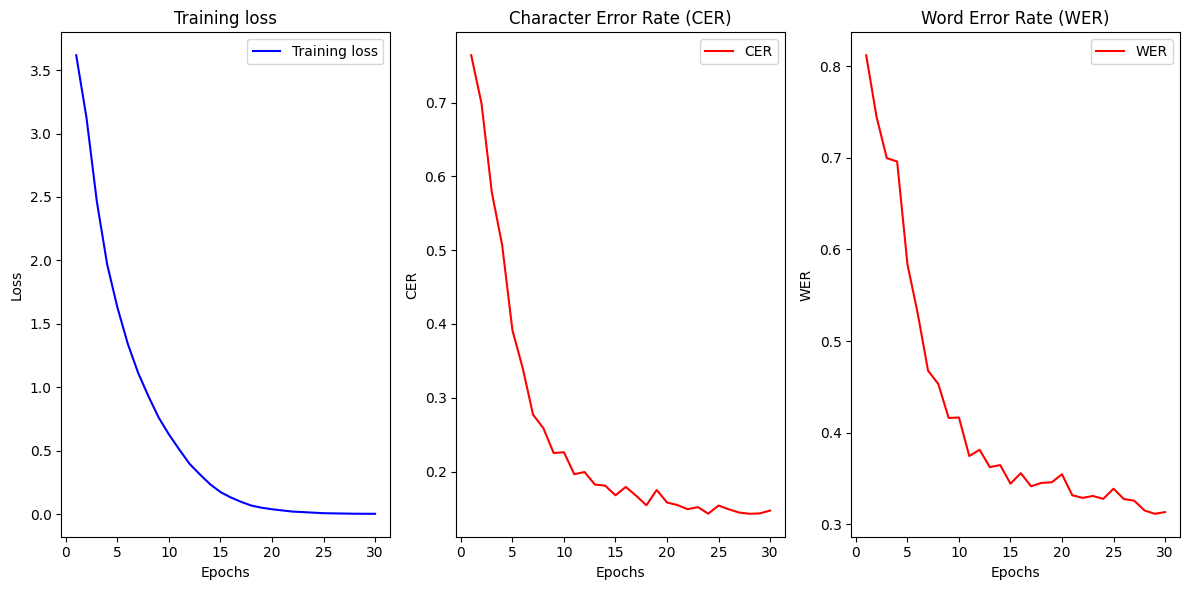

In [46]:
import matplotlib.pyplot as plt

# Assuming loss and CER contain values for each epoch
epochs = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_list, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, CER_list, 'r', label='CER')
plt.title('Character Error Rate (CER)')
plt.xlabel('Epochs')
plt.ylabel('CER')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, WER_list, 'r', label='WER')
plt.title('Word Error Rate (WER)')
plt.xlabel('Epochs')
plt.ylabel('WER')
plt.legend()

plt.tight_layout()
plt.show()

Label: شاكر
Generated: ياسر


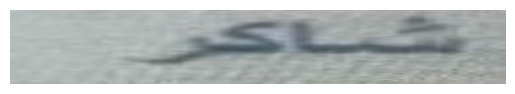

Label: سعيد
Generated: سعيد


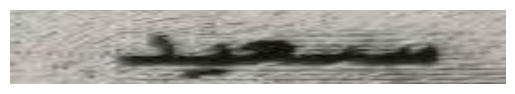

Label: محمد
Generated: محمد


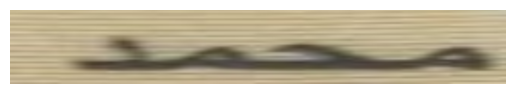

Label: عطيات
Generated: عطيت


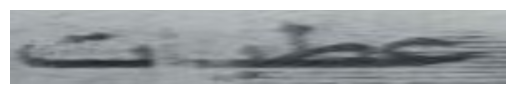

Label: بركات
Generated: سرحان


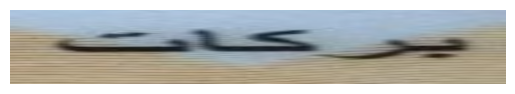

Label: محمد
Generated: محمد


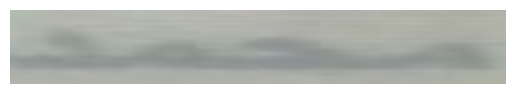

Label: عطيه
Generated: عطيه


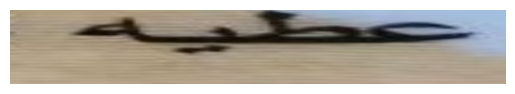

Label: جارحي
Generated: ورد


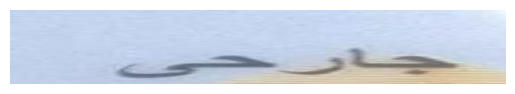

Label: عمر
Generated: عمر


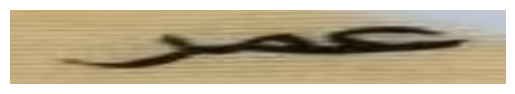

Label: السيد
Generated: السيد


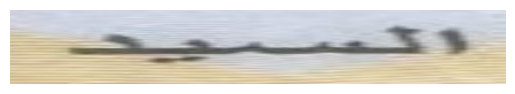

Label: نجلاء
Generated: نجلاء


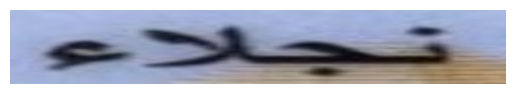

Label: محمد
Generated: محمد


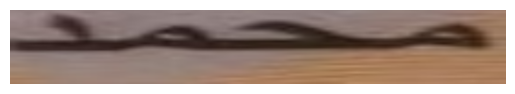

Label: السنهورى
Generated: السنهوري


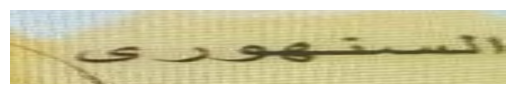

Label: الزكير
Generated: الزعي


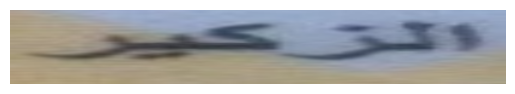

Label: على
Generated: علي


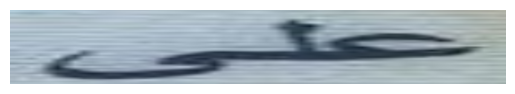

Label: جمعه
Generated: سعد


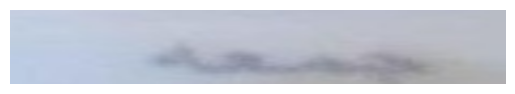

Label: ابراهيم
Generated: ابراهيم


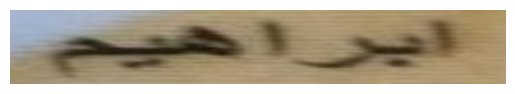

Label: علي
Generated: على


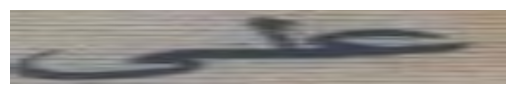

Label: محمد
Generated: محمد


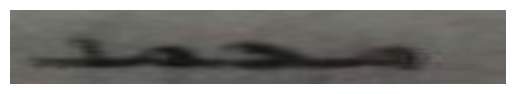

Label: محمد
Generated: محمد


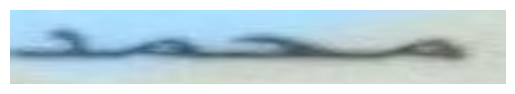

In [47]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import os

# Ensure test_df and device are defined before running this script
# test_df = pd.read_csv("your_test_data.csv")  # Example loading
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the display function
def display_image_with_text(image_path, label, text, size=(300, 2000)):
    image = plt.imread(image_path)

    # Convert float images (matplotlib loads some formats as float)
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size),
        transforms.ToTensor()
    ])

    image_tensor = transform(image)

    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    plt.imshow(image_np)
    print("Label: " + label)
    print("Generated: " + text)
    plt.axis('off')
    plt.show()


# Generate predictions for the test set
for index, row in test_df.head(20).iterrows():
    # Load the image
    image_path = row['image_path']
    original_label = row['label']

    # Load the image and convert it if needed
    image = plt.imread(image_path)
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((384, 384)),
        transforms.ToTensor()
    ])

    image_tensor = transform(image).unsqueeze(0).to(device)

    # Generate prediction
    with torch.no_grad():  # Disable gradient calculations for inference
        outputs = model.generate(image_tensor)

    # Decode output properly
    predicted_text = processor.tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    # Display the image with original and predicted text
    display_image_with_text(image_path, original_label, predicted_text)


In [54]:
from PIL import Image
import torch
from torchvision import transforms
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM  # adjust import based on your model type

# Load the best model and corresponding tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained("/kaggle/working/model.safetensors")
tokenizer = AutoTokenizer.from_pretrained("/kaggle/working/model.safetensors")
model.to(device)
model.eval()

# Define the image preprocessing transform.
# Adjust these parameters (size, mean, std) as used in your training.
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # adjust size as needed
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # example values for ImageNet
                         std=[0.229, 0.224, 0.225]),
])

# Load your input image.
input_image = Image.open("/kaggle/input/imagedf/Screenshot 2025-03-19 144413.png").convert("RGB")
input_tensor = preprocess(input_image).unsqueeze(0).to(device)  # add batch dimension

# Generate output from the model.
with torch.no_grad():
    # If your model uses generate, pass the tensor accordingly.
    outputs = model.generate(input_tensor)

# Decode the output token IDs to text.
result_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
print("Model output:", result_text)


OSError: Incorrect path_or_model_id: '/kaggle/working/model.safetensors'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

Label: original_label
Generated: صلاح


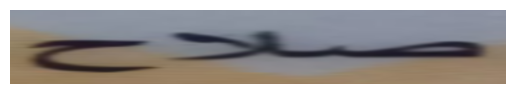

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms
im_path = "/kaggle/input/zxvxcxccv/Screenshot 2025-03-19 154051.png"
# Load the image using plt.imread
image = plt.imread(im_path)

# If image is float, convert to uint8
if image.dtype == np.float32 or image.dtype == np.float64:
    image = (image * 255).astype(np.uint8)

# Convert the NumPy array to a PIL Image and then to RGB
image = Image.fromarray(image).convert("RGB")

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor()
])

# Transform the image and add batch dimension
image_tensor = transform(image).unsqueeze(0).to(device)

# Generate prediction
with torch.no_grad():  # Disable gradient calculations for inference
    outputs = model.generate(image_tensor)

# Decode output properly
predicted_text = processor.tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

# Display the image with original and predicted text
display_image_with_text(im_path, "original_label", predicted_text)
